In [1]:
# Load required python libraries

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
sns.set()

## I. Data Collection

Read the raw data from CSV file and load into pandas dataframe

In [2]:
df_lbag_raw=pd.read_csv('Data_miniproject.csv');
df_lbag_raw.head()

,Cost,Weight,Weight1,Length,Height,Width
0,242.0,23.2,25.4,30.0,11.5200,4.0200
1,290.0,24.0,26.3,31.2,12.4800,4.3056
2,340.0,23.9,26.5,31.1,12.3778,4.6961
3,363.0,26.3,29.0,33.5,12.7300,4.4555
4,430.0,26.5,29.0,34.0,12.4440,5.1340


In [3]:
# Display no of rows and columns in a given input dataset
rows, cols = df_lbag_raw.shape

print ("Number of Rows:", rows)
print ("Number of Columns:", cols)

Number of Rows: 159
Number of Columns: 6


## II. Exploratory Data Anlaysis

Rename the column 'Weight1' to 'Exp_weight' (expanded weight)

In [4]:
df_lbag_raw.rename(columns={'Weight1':'Exp_weight'}, inplace=True)
df_lbag_raw.head()

,Cost,Weight,Exp_weight,Length,Height,Width
0,242.0,23.2,25.4,30.0,11.5200,4.0200
1,290.0,24.0,26.3,31.2,12.4800,4.3056
2,340.0,23.9,26.5,31.1,12.3778,4.6961
3,363.0,26.3,29.0,33.5,12.7300,4.4555
4,430.0,26.5,29.0,34.0,12.4440,5.1340


#### <u>**Data type check**</u>

In [5]:
df_lbag_raw.dtypes

Cost          float64
Weight        float64
Exp_weight    float64
Length        float64
Height        float64
Width         float64
dtype: object

Since no categorical varaibles are present, no need to set "include all" in describe function to see all variable stats.

In [6]:
df_lbag_raw.describe()

,Cost,Weight,Exp_weight,Length,Height,Width
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,398.326415,26.247170,28.415723,31.227044,8.970994,4.417486
std,357.978317,9.996441,10.716328,11.610246,4.286208,1.685804
min,0.000000,7.500000,8.400000,8.800000,1.728400,1.047600
25%,120.000000,19.050000,21.000000,23.150000,5.944800,3.385650
50%,273.000000,25.200000,27.300000,29.400000,7.786000,4.248500
75%,650.000000,32.700000,35.500000,39.650000,12.365900,5.584500
max,1650.000000,59.000000,63.400000,68.000000,18.957000,8.142000


#### <u>**Null check**</u>

In [7]:
# check the numbers of null or NaN values column wise
df_lbag_raw.isnull().sum()

Cost          0
Weight        0
Exp_weight    0
Length        0
Height        0
Width         0
dtype: int64

None of the columns have null or Nan values. we can proceed with this dataset further without deleting any records

#### <u>**Correlations**</u>

In [8]:
df_corr=df_lbag_raw.corr()

# Excluding the target variable as there is no need to check the self correlation 
filter = df_corr['Cost'].index != 'Cost' 
df_corr=df_corr['Cost'][ filter ]

# Sorting the variables by correlation values in descending order
df_corr.sort_values(ascending=False).round(2)

Length        0.92
Exp_weight    0.92
Weight        0.92
Width         0.89
Height        0.72
Name: Cost, dtype: float64

#### <u>**Correlations Heatmap**</u>

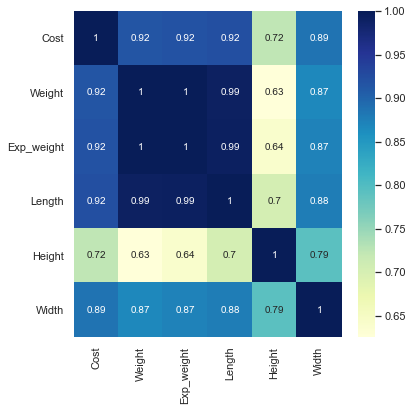

In [9]:
plt.figure(figsize=(6,6))
sns.heatmap(df_lbag_raw.corr(), annot=True, cmap='YlGnBu')
plt.show()

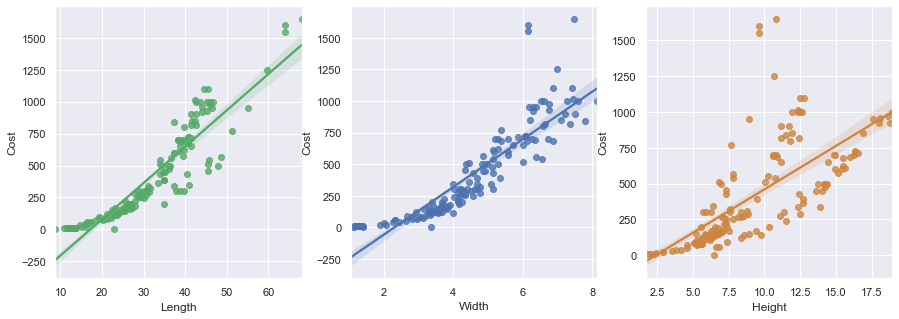

In [10]:
# Regplot for bag dimensions (i.e. lenght, width, heigth) as we know that they are dependent on each other
fig, ax=plt.subplots(1, 3, figsize=(15,5))
sns.regplot(x='Length', y='Cost', data=df_lbag_raw, ax=ax[0], color='g')
sns.regplot(x='Width', y='Cost', data=df_lbag_raw, ax=ax[1], color='b')
sns.regplot(x='Height', y='Cost', data=df_lbag_raw, ax=ax[2], color='peru')
plt.show()

As expected, above scatter/reg plots show that two dimensions (i.e. length & width) are similarly varying with target/dependent variable i.e. "Cost". Also we can observe that the relation is not linear.

In [11]:
# Lets merge it into one varaible i.e. say Area = Length * Width
lbag_Area=df_lbag_raw['Length']*df_lbag_raw['Width']
lbag_Area.head()

0    120.60000
1    134.33472
2    146.04871
3    149.25925
4    174.55600
dtype: float64

In [12]:
# Add the above derived Area to the dataframe

df_lbag_trnsf=pd.concat([df_lbag_raw, lbag_Area.rename('Area')], axis=1)
df_lbag_trnsf.head()

,Cost,Weight,Exp_weight,Length,Height,Width,Area
0,242.0,23.2,25.4,30.0,11.5200,4.0200,120.60000
1,290.0,24.0,26.3,31.2,12.4800,4.3056,134.33472
2,340.0,23.9,26.5,31.1,12.3778,4.6961,146.04871
3,363.0,26.3,29.0,33.5,12.7300,4.4555,149.25925
4,430.0,26.5,29.0,34.0,12.4440,5.1340,174.55600


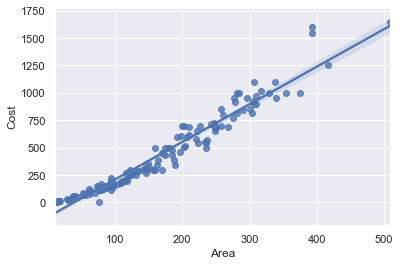

In [13]:
# Regplot for 'Area' and 'Cost' variable

sns.regplot(x='Area', y='Cost', data=df_lbag_trnsf)
plt.show()

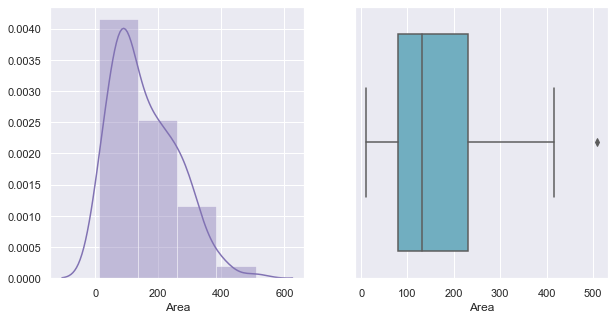

In [14]:
# Distribution & Box plot for 'Area'

fig, ax =plt.subplots(1, 2, figsize=(10,5))
sns.distplot(df_lbag_trnsf['Area'], bins=4, ax=ax[0], color='m')
sns.boxplot(df_lbag_trnsf['Area'], ax=ax[1], color='c')
plt.show()

Let's create a function to get the outlier stats of a variable. Both 99 & 95 quantiles have been considered just to analyze number of outliers so that we can decide which quantile value should be considered for dropping the ouliers with minimal impact

In [15]:
def outlier_stats(s_feature):
    
    # 99 & 95 quantile values of given feature
    p99=s_feature.quantile(q=.99)
    p95=s_feature.quantile(q=.95)

    # no. of values outside the quantiles range 
    outlier99=s_feature[s_feature > p99].shape[0]
    outlier95=s_feature[s_feature > p95].shape[0]
    
    # total no. of rows in our dataset
    rows=s_feature.shape[0]

    print ("With 99% quantile: {} out of {} are outliers".format(outlier99, rows, outlier99/rows))
    print ("With 95% quantile: {} out of {} are outliers".format(outlier95, rows, outlier95/rows))

In [16]:
# Let's call the function for 'Area' feature

outlier_stats(df_lbag_trnsf['Area'])

With 99% quantile: 2 out of 159 are outliers
With 95% quantile: 8 out of 159 are outliers


In [17]:
# We will discard the outliers that exceeds 99% quantile range

q=df_lbag_trnsf['Area'].quantile(.99)
df_lbag_trnsf = df_lbag_trnsf[ df_lbag_trnsf['Area'] < q ]

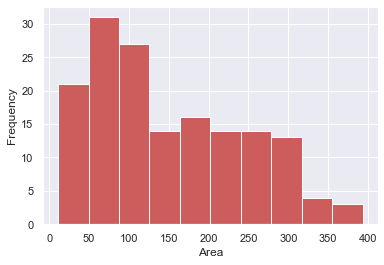

In [18]:
# Let's plot the Histogram for Area feature

n, bins, _ = plt.hist(df_lbag_trnsf['Area'], bins=10, color='indianred')
#plt.xticks(np.round_(bins,0))
plt.xlabel('Area')
plt.ylabel('Frequency')
plt.show()

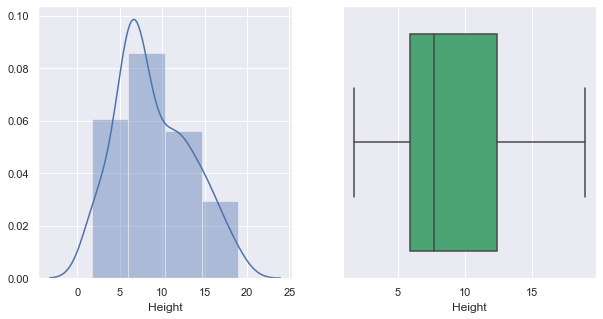

In [19]:
# Distribution & Box plot for 'Height'

fig, ax =plt.subplots(1, 2, figsize=(10,5))
sns.distplot(df_lbag_trnsf['Height'], bins=4, ax=ax[0])
sns.boxplot(df_lbag_trnsf['Height'], ax=ax[1], color='mediumseagreen')
plt.show()

In [20]:
# Let's call the function for 'Height' feature

outlier_stats(df_lbag_trnsf['Height'])

With 99% quantile: 2 out of 157 are outliers
With 95% quantile: 8 out of 157 are outliers


In [21]:
# We will discard the outliers that exceeds 99% quantile range

q=df_lbag_trnsf['Height'].quantile(.99)
df_lbag_trnsf = df_lbag_trnsf[ df_lbag_trnsf['Height'] < q ]

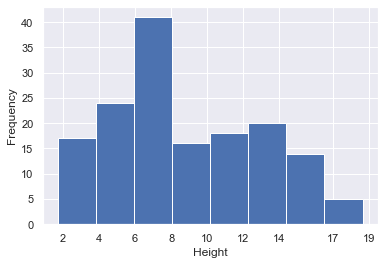

In [22]:
# Let's plot the Histogram for Height feature

n, bins, _ = plt.hist(df_lbag_trnsf['Height'], bins=8)
plt.xticks(np.round_(bins,0))
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.show()

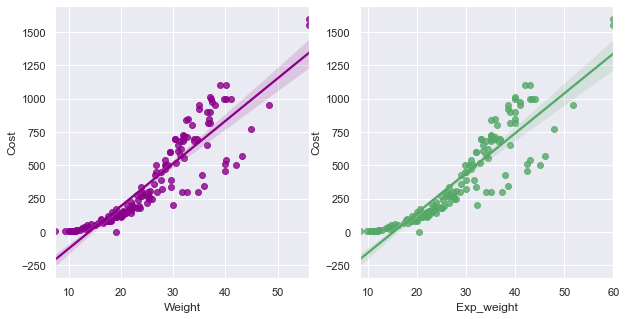

In [23]:
# Regplot for bag weight featues 

fig, ax=plt.subplots(1, 2, figsize=(10,5))
sns.regplot(x='Weight', y='Cost', data=df_lbag_trnsf, ax=ax[0], color='darkmagenta')
sns.regplot(x='Exp_weight', y='Cost', data=df_lbag_trnsf, ax=ax[1], color='g')
plt.show()

In [24]:
# Again it looks both are having similar relationship with dependent variable i.e. 'Cost'
# Let's create one common weight feature by taking average of both

df_lbag_trnsf['Avg_weight']=df_lbag_trnsf[['Weight', 'Exp_weight']].mean(axis=1)
df_lbag_trnsf.head()

,Cost,Weight,Exp_weight,Length,Height,Width,Area,Avg_weight
0,242.0,23.2,25.4,30.0,11.5200,4.0200,120.60000,24.30
1,290.0,24.0,26.3,31.2,12.4800,4.3056,134.33472,25.15
2,340.0,23.9,26.5,31.1,12.3778,4.6961,146.04871,25.20
3,363.0,26.3,29.0,33.5,12.7300,4.4555,149.25925,27.65
4,430.0,26.5,29.0,34.0,12.4440,5.1340,174.55600,27.75


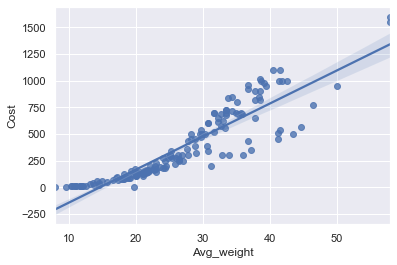

In [25]:
# Reg plot for Avg weight feature

sns.regplot(x='Avg_weight', y='Cost', data=df_lbag_trnsf)
plt.show()

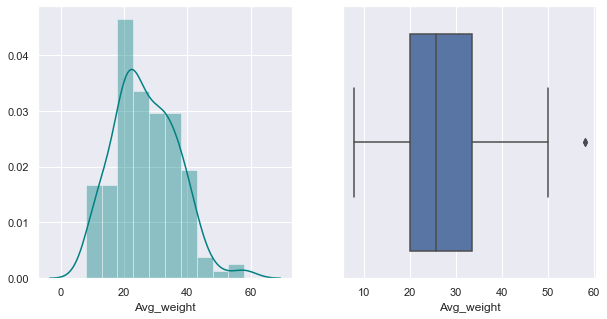

In [26]:
# Distribution & Box plot for 'Average weight of bag'

fig, ax =plt.subplots(1, 2, figsize=(10,5))
sns.distplot(df_lbag_trnsf['Avg_weight'], ax=ax[0], color='teal')
sns.boxplot(df_lbag_trnsf['Avg_weight'], ax=ax[1])
plt.show()

From above box plot we can see that there are outliers. So we will see the outlier stats for Avg weight using the function we have created earlier

In [27]:
outlier_stats(df_lbag_trnsf['Avg_weight'])

With 99% quantile: 2 out of 155 are outliers
With 95% quantile: 8 out of 155 are outliers


In [28]:
# Considering small dataset available, we cannot afford to lose many observations. So, we will go with 99% quantile..

q=df_lbag_trnsf['Avg_weight'].quantile(.99)
df_lbag_trnsf = df_lbag_trnsf[ df_lbag_trnsf['Avg_weight'] < q ]

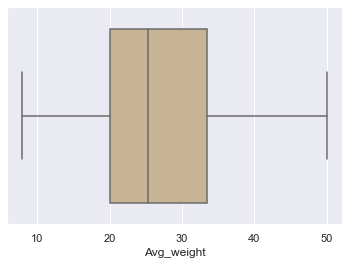

In [29]:
# Let's create a box plot again..

sns.boxplot(df_lbag_trnsf['Avg_weight'], color='tan')
plt.show()

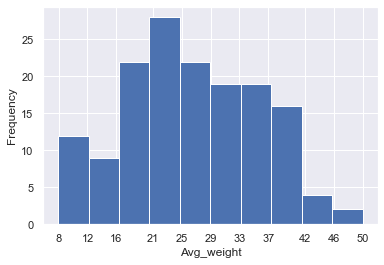

In [30]:
# Let's plot the Histogram for Average weight feature

n, bins, _ = plt.hist(df_lbag_trnsf['Avg_weight'])

# to sync the xticks with histogram 
plt.xticks(np.round_(bins,0))
plt.xlabel('Avg_weight')
plt.ylabel('Frequency')

plt.show()

In [31]:
# with two additional dervied features, let's check the overall dataframe stats for one more time 
df_lbag_trnsf.describe()

,Cost,Weight,Exp_weight,Length,Height,Width,Area,Avg_weight
count,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000
mean,361.822876,25.363399,27.465359,30.205882,8.810317,4.328592,146.084544,26.414379
std,307.170695,8.889369,9.538705,10.418867,4.211673,1.653681,91.629034,9.212666
min,0.000000,7.500000,8.400000,8.800000,1.728400,1.047600,11.314080,7.950000
25%,120.000000,19.000000,21.000000,22.800000,5.917500,3.351600,78.440670,20.000000
50%,270.000000,24.100000,26.500000,29.000000,7.585200,4.234000,124.481050,25.300000
75%,600.000000,31.900000,35.000000,39.200000,12.354000,5.355000,210.519680,33.400000
max,1100.000000,48.300000,51.700000,55.100000,18.635400,8.142000,374.532000,50.000000


In [32]:
# with two additional dervied features, let's check the overall dataframe stats for one more time

df_corr=df_lbag_trnsf.corr()

# Excluding the target variable as there no need to check the self correlation 
filter = df_corr['Cost'].index != 'Cost' 
df_corr=df_corr['Cost'][ filter ]

# Sorting the variables by correlation values in descending order
df_corr.sort_values(ascending=False).round(2)

Area          0.98
Width         0.92
Length        0.90
Exp_weight    0.90
Avg_weight    0.89
Weight        0.89
Height        0.81
Name: Cost, dtype: float64

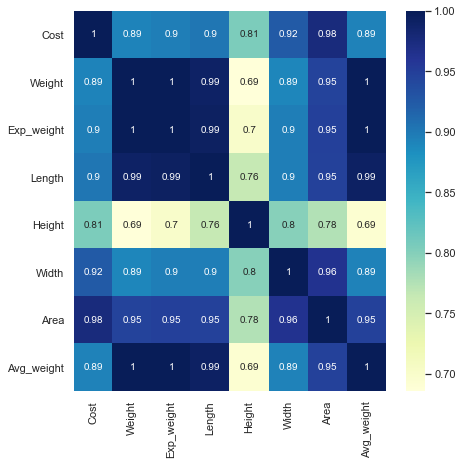

In [33]:
# We can see that derived feature - Area is highly correlated compared to original dimensions. Let's create a updated heatmap..

plt.figure(figsize=(7,7))
sns.heatmap(df_lbag_trnsf.corr(), annot=True, cmap='YlGnBu')
plt.show()

In [34]:
# Set Model features (with derived variables)

X=df_lbag_trnsf[['Avg_weight', 'Area', 'Height']].values
y=df_lbag_trnsf['Cost'].values

X.shape, y.shape

((153, 3), (153,))

## III. Model building

### Train Test Split

In [35]:
# Creating train test split with 7:3 ratio

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6, shuffle=True)

# As the values in dataset are having different ranges, we need to standardize the features to bring into one scale
X_train=StandardScaler().fit_transform(X_train)
X_test=StandardScaler().fit_transform(X_test)

# train & test datasets size
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((107, 3), (107,), (46, 3), (46,))

### 1. Sklearn

In [36]:
from sklearn.preprocessing import PolynomialFeatures

# To analyse and find the degree of the model
for i in range(1,6):
    
    x_poly_train=PolynomialFeatures(degree=i).fit_transform(X_train)
    x_poly_test=PolynomialFeatures(degree=i).fit_transform(X_test)

    lin_reg=LinearRegression()
    lin_reg.fit(x_poly_train ,y_train)
    
    print("Degree- {}   Train score: {:.2f}   Testscore: {:.2f}".format(i, lin_reg.score(x_poly_train, y_train),
                                                                 lin_reg.score(x_poly_test, y_test)))

Degree- 1   Train score: 0.97   Testscore: 0.95
Degree- 2   Train score: 0.99   Testscore: 0.97
Degree- 3   Train score: 0.99   Testscore: 0.97
Degree- 4   Train score: 0.98   Testscore: 0.70
Degree- 5   Train score: 1.00   Testscore: -0.95


In [37]:
# We have already seen in EDA that data is not linearly variying i.e. degree 1 is not going to be suitable.
# Degree 3 & higher seems to be not the good fit

# Transforming the input variables into 2nd degree 
Xpoly_train=PolynomialFeatures(degree=2).fit_transform(X_train)
Xpoly_test=PolynomialFeatures(degree=2).fit_transform(X_test)

lin_reg=LinearRegression()
lin_reg.fit(Xpoly_train ,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [38]:
# Model coefficients/parameters & Intercept

print("Model coefficients:", np.round_(lin_reg.coef_,2))
print("Model Intercept:", np.round_(lin_reg.intercept_,2))

Model coefficients: [  0.    58.31 207.88  71.96  17.29 -15.12  99.67   0.55   2.92 -42.08]
Model Intercept: 330.51


In [39]:
# Cross validating the model
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle

df=shuffle(df_lbag_trnsf).reset_index(drop=True)
X=df[['Avg_weight', 'Area', 'Height']].values
y=df['Cost'].values

X=StandardScaler().fit_transform(X)
Xp=PolynomialFeatures(degree=2).fit_transform(X)

# Cross validation with 10 folds
cv_scores=cross_val_score(lin_reg, Xp, y, cv=10)
print ("Cross validation score: {:.2f}".format(np.mean(cv_scores)))

Cross validation score: 0.97


In [40]:
from sklearn.metrics import mean_squared_error

def model_evaluation(X, y, model, package_name):
    
    # Model predictions
    y_pred_ts=model.predict(X)
    rec_count=X.shape[0]

    # Mean squared error
    mse = mean_squared_error(y, y_pred_ts)
    rmse = math.sqrt(mse)

    # residual standard error
    rse = mse * rec_count
    rse /= rec_count-2 
    rse = math.sqrt(rse)
    
    # R2 score
    r2_score=model.score(X, y)

    model_eval=pd.DataFrame([mse, rmse, rse, r2_score], columns=[package_name])
    model_eval.index=['Mean Sqaured Error (MSE)', 'Root MSE (RMSE)', 'Residual Std Error (RSE)', 'R2 Score']
    
    return model_eval.round(2)

In [41]:
# call the above function to evaluate Sklearn regression model
Sklearn_eval=model_evaluation(Xpoly_test, y_test, lin_reg, 'Sklearn')
Sklearn_eval

,Sklearn
Mean Sqaured Error (MSE),2979.72
Root MSE (RMSE),54.59
Residual Std Error (RSE),55.81
R2 Score,0.97


### 2. Stochastic Gradient Descent

In [42]:
from sklearn.linear_model import SGDRegressor

# Using  SGD regressor from sklearn library
sgd_reg = SGDRegressor(max_iter=100000, tol=1e-4, eta0=1e-2, fit_intercept=False)
sgd_reg.fit(Xpoly_train, y_train)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=False, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=100000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [43]:
# Model coefficients/parameters & Intercept

print("Model coefficients:", np.round_(sgd_reg.coef_,2))
print("Model Intercept:", np.round_(sgd_reg.intercept_,2))

Model coefficients: [291.57 103.3  116.49  81.47 -14.02  13.    12.4   49.04  14.46   3.12]
Model Intercept: [0.]


In [44]:
# SGD Cross validation score

cv_scores=cross_val_score(sgd_reg, Xp, y, cv=10)
print ("Cross validation score: {:.2f}".format(np.mean(cv_scores)))

Cross validation score: 0.97


In [45]:
# Call evaluation funcation for SGD model
SGD_eval=model_evaluation(Xpoly_test, y_test, sgd_reg, 'SGD')
SGD_eval

,SGD
Mean Sqaured Error (MSE),3137.00
Root MSE (RMSE),56.01
Residual Std Error (RSE),57.27
R2 Score,0.97


### 3. Batch Gradient Descent

In [46]:
# Reshaping target variable into vector
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [47]:
# Cost function
def  cal_cost(theta,X,y):
    '''
    
    Calculates the cost for given X and Y. The following shows and example of a single dimensional X
    theta = Vector of thetas 
    X     = Row of X's np.zeros((2,j))
    y     = Actual y's np.zeros((2,1))
    
    where:
        j is the no of features
    '''
    
    m = len(y)
    
    predictions = X.dot(theta)
    cost = (1/2*m) * np.sum(np.square(predictions-y))
    return cost

In [48]:
# Gradient descent function
def gradient_descent(X,y,theta,learning_rate=0.01,iterations=100):
    '''
    X    = Matrix of X with added bias units
    y    = Vector of Y
    theta=Vector of thetas np.random.randn(j,1)
    learning_rate 
    iterations = no of iterations
    
    Returns the final theta vector and array of cost history over no of iterations
    '''
    m = len(y)
    cost_history = np.zeros(iterations)
    theta_history = np.zeros((iterations,X.shape[1]))
    for i in range(iterations):
        
        prediction = np.dot(X,theta)
        
        theta = theta -(1/m)*learning_rate*( X.T.dot((prediction - y)))
        theta_history[i,:] =theta.T
        cost_history[i]  = cal_cost(theta,X,y)
        
    return theta, cost_history, theta_history

In [49]:
# Set gradient descent parameters
lr =0.1
n_iter = 15000
cols = Xpoly_train.shape[1]+1

theta = np.random.randn(cols,1)

# Adding default bias term for theta_0
Xpoly_train_B = np.c_[np.ones((len(Xpoly_train),1)), Xpoly_train]
Xpoly_test_B = np.c_[np.ones((len(Xpoly_test),1)), Xpoly_test]

theta,cost_history,theta_history = gradient_descent(Xpoly_train_B, y_train, theta, lr, n_iter)

print('Theta values:\n', theta)
print('\nFinal training cost/RMSE:  {:0.3f}'.format(math.sqrt(cost_history[-1])))

Theta values:
 [[ 1.65811998e+02]
 [ 1.64718876e+02]
 [ 5.82767084e+01]
 [ 2.07943252e+02]
 [ 7.19307255e+01]
 [ 1.69339765e+01]
 [-1.42152994e+01]
 [ 9.93539286e+01]
 [ 2.10276852e-02]
 [ 3.23147346e+00]
 [-4.20894420e+01]]

Final training cost/RMSE:  2764.822


In [50]:
from sklearn.metrics import r2_score

def gd_model_evaluation(X, y, Theta, package_name):

    # Model predictions
    yhat = X.dot(theta)
    rec_count=X.shape[0]
    
    # Mean Squared Error
    mse = mean_squared_error(y, yhat)
    rmse = math.sqrt(mse)

    # Residual Standard Error
    rse = mse * rec_count
    rse /= rec_count-2 
    rse = math.sqrt(rse)
    
    # R2_score
    r2_scr=r2_score(y, yhat)
    
    model_eval=pd.DataFrame([mse, rmse, rse, r2_scr], columns=[package_name])
    model_eval.index=['Mean Sqaured Error (MSE)', 'Root MSE (RMSE)', 'Residual Std Error (RSE)', 'R2 Score']
    
    return model_eval.round(2)

In [51]:
# Function call for Batch gradient descent evaluation
Batch_GD=gd_model_evaluation(Xpoly_test_B, y_test, theta, 'Batch GD')
Batch_GD

,Batch GD
Mean Sqaured Error (MSE),2979.44
Root MSE (RMSE),54.58
Residual Std Error (RSE),55.81
R2 Score,0.97


### 4. Mini Batch Gradient Descent

In [52]:
def minibatch_gradient_descent(X,y,theta,learning_rate=0.01,iterations=10,batch_size =30):
    '''
    X    = Matrix of X without added bias units
    y    = Vector of Y
    theta=Vector of thetas np.random.randn(j,1)
    learning_rate 
    iterations = no of iterations
    
    Returns the final theta vector and array of cost history over no of iterations
    '''
    m = len(y)
    cost_history = np.zeros(iterations)
    n_batches = int(m/batch_size)
    
    for it in range(iterations):
        cost =0.0
        indices = np.random.permutation(m)
        X = X[indices]
        y = y[indices]
        for i in range(0,m,batch_size):
            X_i = X[i:i+batch_size]
            y_i = y[i:i+batch_size]
            
            X_i = np.c_[np.ones(len(X_i)),X_i]
           
            prediction = np.dot(X_i,theta)

            theta = theta -(1/m)*learning_rate*( X_i.T.dot((prediction - y_i)))
            cost += cal_cost(theta,X_i,y_i)
        cost_history[it]  = cost
        
    return theta, cost_history

In [53]:
# Set gradient descent parameters
lr =0.1
n_iter = 5000

# Initializing theta with random numbers
theta = np.random.randn(cols,1)

theta, cost_history = minibatch_gradient_descent(Xpoly_train, y_train, theta, lr, n_iter)

print('Theta values:\n', theta)
print('\nFinal traning cost/RMSE:  {:0.3f}'.format(math.sqrt(cal_cost(theta, Xpoly_train_B, y_train))))

Theta values:
 [[165.13263023]
 [165.27968897]
 [ 60.03872262]
 [206.47268327]
 [ 71.74092382]
 [ 13.0210424 ]
 [ -6.14341095]
 [ 98.30266934]
 [ -4.62643307]
 [  4.71044672]
 [-42.69995571]]

Final traning cost/RMSE:  2767.671


In [54]:
# Call evaluation function for Mini batch GD
Mini_Batch_GD=gd_model_evaluation(Xpoly_test_B, y_test, theta, 'MiniBatch GD')
Mini_Batch_GD

,MiniBatch GD
Mean Sqaured Error (MSE),2959.02
Root MSE (RMSE),54.40
Residual Std Error (RSE),55.62
R2 Score,0.97


### <u>Models comparison<u/>

Let's compare the different models we have build using different techiniques and we will see how close they are.

In [55]:
pd.concat([Sklearn_eval, SGD_eval, Batch_GD, Mini_Batch_GD], axis=1)

,Sklearn,SGD,Batch GD,MiniBatch GD
Mean Sqaured Error (MSE),2979.72,3137.00,2979.44,2959.02
Root MSE (RMSE),54.59,56.01,54.58,54.40
Residual Std Error (RSE),55.81,57.27,55.81,55.62
R2 Score,0.97,0.97,0.97,0.97
